# Feature importance

#### Philippe Pinel
13th June 2019

## Description

The metrics used by each algorithm to get the feature importance are different, so using them to compare the feature selected between each algorithm is to be nuanced. Here we propose a function that will use the same metric: compare the concordance index before and after shuffling the feature we want to test the importance. Here is an overview of how it works:

**Feature Importance Algorithm**

*Input: model, predictive algorithm, number of repetitions, features to test the importance, number of permutation*



    for each repetition {
    
            create 5 (training, testing) sets for internal cross validation  
            
            for each (training, testing) set {
            
                    train model and evaluate reference concordance index

                    for each feature {

                            for each permutation {

                                    shuffle feature in testing set
                                    predict
                                    evaluate shuffled concordance index
                                    compare to the reference concordance index

                            }
                    }
            }   
    }


*Output: differences between reference CI and CI obtained from shuffling data for each feature tested*


This way we minimize the number of model trainings (= `n_repeat*5`) without introducing too much bias thanks to the several cross-validations, even though we will have many predictions to compute.





In [1]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library('grid')
library('gridExtra')
library('ggthemes')
library('stringr')


source("../../src/tools.R")
source("../../src/merge_df.R")
source("../../src/my_survival.R")

theme_set(theme_bw())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

Loading required package: magrittr
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: parallel
Loading required package: RColorBrewer

 randomForestSRC 2.8.0 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 

Loading required package: prodlim


In [2]:
# -------------- DATA -------------- #
# CLINICAL DF
ddc = read.table("../../data/updated_dataset/df_clinical_cyto_selected_process_ippsr.tsv",stringsAsFactors=F,header=T,sep="\t")
# MUTATIONS MAF
ddmaf = read.table("../../data/updated_dataset/df_maf_driver_selected.tsv",stringsAsFactors=F,header=T,sep="\t")
# CYTO DF
ddcyto = read.table("../../data/updated_dataset/df_cyto_binary_impute.tsv",stringsAsFactors=F,header=T,sep="\t")
# COMPONENTS DF
#ddcomponents = read.table("../../data/updated_dataset/df_components.tsv",stringsAsFactors=F,header=T,sep="\t")
# GENE INTERACTION DF
#ddint_double = read.table("../../data/updated_dataset/datagene_interactions_duplicate_cut1_v2.tsv",stringsAsFactors=F,header=T,sep="\t")
#ddint_triple = read.table("../../data/updated_dataset/datagene_interactions_triplicate_cut2_v2.tsv",stringsAsFactors=F,header=T,sep="\t")
# ---------------------------------- #
if(identical(ddc$LEUKID,ddcyto$LEUKID)) print("all good")
# CREATE MUTATIONS DF
res = merge_clinical_mutation(dd_clinical=ddc, dd_maf=ddmaf, binary=FALSE, col_field="EVENT")
#dd = res$ddmerge # merge
#ddmut = res$ddmut # binary mutation matrix
#if(identical(ddc$LEUKID,rownames(ddmut))) print("all good ^ 2")
# ---------------------------------- #
# ADD METRIC
ddc$AGE = round(ddc$AGE_AT_SAMPLE_TIME)
# -> number of cyto aberrations
ddcyto.reduce = ddcyto[,-which(colnames(ddcyto)%in%c("LEUKID","del4q24"))]
ddc$num_cyto_aberrations = apply(ddcyto.reduce,1,sum)
# -> correct for r_1_7
j17 = which(ddcyto[,"r_1_7"]==1 & ddcyto[,"plus1q"]==1 & ddcyto[,"del7q"]==1)
ddc$num_cyto_aberrations[j17] = ddc$num_cyto_aberrations[j17] - 1
# -> correct for iso17q
jiso17 = which(ddcyto[,"iso17q"]==1 & ddcyto[,"del17p"]==1 & ddcyto[,"plus17q"]==1)
ddc$num_cyto_aberrations[jiso17] = ddc$num_cyto_aberrations[jiso17] - 1
# -> total number of mutations + del4q24
ddc$num_mutations = apply(res$ddmut,1,sum) + ddcyto[,"del4q24"]
## event free survival
ddc$time<-with(ddc,ifelse(aml_status==0,os_diag_years,aml_diag_years))
ddc$status<-with(ddc,ifelse(aml_status==0,os_status,1))
# ---------------------------------- #
# GET READY DATAFRAMES FOR PREDICTIONS
# ddc is clinical df
# ddmutation
ddmut5 = read.table("../../data/updated_dataset/df_mut_hotspot_cut5.tsv", stringsAsFactors=F, header=T, sep="\t")
# cyto with features NK and CK
ddcyto5 = read.table("../../data/updated_dataset/df_cyto_binary_impute_cut5.tsv", stringsAsFactors=F, header=T, sep="\t")
id <-ddcyto5[,1]
rownames(ddcyto5)<-id
ddcyto5<-ddcyto5[ddc$LEUKID,]
ddcyto5 = ddcyto5[,-1]
ddcyto5$NK = 0
ddcyto5$NK[ddc$num_cyto_aberrations==0] = 1
ddcyto5$CK = 0
ddcyto5$CK[ddc$num_cyto_aberrations>=3] = 1
# ---------------------------------- #
# WITH TP53 ALLELIC STATUS
ddtp53 = read.table("../../data/updated_dataset/LEUKID_P53_status.tsv",sep="\t",header=T,stringsAsFactors=F)
rownames(ddtp53) = ddtp53$LEUKID ; ddtp53 = ddtp53[,-1]
ddtp53 = ddtp53[ddc$LEUKID,]
ddmut5[,"TP53"] = NULL
rownames(ddmut5)<-id
ddmut5<-ddmut5[ddc$LEUKID,]
ddmut5 = cbind(ddmut5,ddtp53)
ddmut5[,"U2AF1"]=ddmut5[,"U2AF1_157"]+ddmut5[,"U2AF1_34"]
ddmut5[,"U2AF1_157"]=NULL
ddmut5[,"U2AF1_34"]=NULL

rec<-colSums(ddcyto5)
rec<-rec[1:(length(rec)-2)]
rec<-sort(rec,decreasing = T)
rec<-rec[1:10]
rec<-names(rec)
# ---------------------------------- #

# ---------------------------------- #
# DEFINE FEATURE GROUPS
# ---------------------------------- #
nuisance = c("CENTER")
ipssr = c("AGE","HB","PLT","ANC","BM_BLAST","CYTO_IPSSR","IPSSR_CALCULATED")
clinicalother = c("SEX")
mutnumber = c("num_mutations")
cytonumber = c("num_cyto_aberrations")
mutations = colnames(ddmut5)
cytoaberrations = colnames(ddcyto5)
age=c("AGE")
ipssr.score=c("IPSSR_CALCULATED")
ipssr.wt.score = c("AGE","HB","PLT","ANC","BM_BLAST","CYTO_IPSSR")
wbc=c("WBC")
#geneint_double=colnames(ddint_double)
#geneint_triple=colnames(ddint_triple)
clin=c("HB","PLT","ANC","BM_BLAST")
#component=c("component")
topcyto=c(rec,"CK","NK")
blast=c("BM_BLAST")

list.features = list(nuisance=nuisance,
                  ipssr=ipssr,
                  clinicalother=clinicalother,
                  mutnumber=mutnumber,
                  cytonumber=cytonumber,
                  mutations=mutations,
                  cytoaberrations=cytoaberrations,
                  age=age,
                  ipssr.score=ipssr.score,
                  ipssr.wt.score=ipssr.wt.score,
                  wbc=wbc,
                  #geneint_double=geneint_double,
                  #geneint_triple=geneint_triple,
                  clin=clin,
                  #component=component,
                  topcyto=topcyto,
                  blast=blast)

# ---------------------------------- #
# COMPLETE CASE FOR OS
# ---------------------------------- #
# COMPLETE CASE WITH OS AND AML RESPONSE 
i.complete = which(ddc$ipssr_complete_case=="complete")
response.name1 = c("os_diag_years","os_status")
tmp = ddc[i.complete,response.name1]
i.survival = i.complete[-which(tmp[,1]<=0 | is.na(tmp[,1]) | is.na(tmp[,2]))]
#ddcomponents = ddcomponents[as.character(ddc$LEUKID),]
ddgo = cbind(ddc,ddmut5,ddcyto5)
#ddgo$component=ddcomponents
ddgo = ddgo[i.survival,]
#ddgo = cbind(ddgo,ddint_double,ddint_triple)


response.name2 = c("aml_diag_years","aml_status")
i.not.aml = which(ddgo$WHO_2016_SIMPLIFY_2!="AML")
tmp2 = ddgo[i.not.aml,response.name2]
i.event.free = i.not.aml[-which(tmp2[,1]<=0 | is.na(tmp2[,1]) | is.na(tmp2[,2]))]

ddgo = ddgo[i.event.free,]

response.name3 = c("time","status")

ddgo = ddgo[,c(unlist(list.features),response.name1,response.name2,response.name3)] 

ddgo[is.na(ddgo[, "WBC"]), "WBC"] <- mean(ddgo[, "WBC"], na.rm = TRUE) # MEAN IMPUTATION FOR WBC MISSING
ddgo$CENTER <- paste0('_', ddgo$CENTER)



[1] "all good"


# CLIN DEMO CYTO GENE

We describe how this algorithm works with the example of *CLIN_DEMO_CYTO_GENE* model (without transformation of clinical features) and the 3 algorithms LASSO, random forests and random effects are used to compare the 3 endpoints OS, AML transformation and event free survival. We perform 3 repetitions of 5-fold CV with 10 permutations each time, which means that for every feature we have 15 training sets and we test on 15 testing sets, and for each testing set we shuffle 10 times. So 150 ratios of CI for each variable. If the ratio is one, it means that shuffling the feature did not change the concordance index. When the ratio is greater than one, it means that shuffling the feature decreased the concordance index.

In [3]:
# CLIN_DEMO_CYTO_GENE
prep.CLIN_DEMO_CYTO_GENE = PrepareDesignMatrix(data=ddgo,
                                 use.nuisance=TRUE,
                                 response.name=c("time","status"),
                                 feature.category.name = c("clin","wbc","age","clinicalother","cytoaberrations","mutations"),
                                 list.features=list.features)


In [4]:
CLIN_DEMO_CYTO_GENE_AML <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_AML_updated_seed.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_AML$endpoint<-'AML'
CLIN_DEMO_CYTO_GENE_EVENT <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_EVENT_FREE_updated_seed.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_EVENT$endpoint<-'EVENT_FREE'
CLIN_DEMO_CYTO_GENE_OS <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_OS_updated_seed.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_OS$endpoint<-'OS'    

CLIN_DEMO_CYTO_GENE<-rbind(CLIN_DEMO_CYTO_GENE_OS,
                           CLIN_DEMO_CYTO_GENE_AML,
                           CLIN_DEMO_CYTO_GENE_EVENT)



In [190]:
head(CLIN_DEMO_CYTO_GENE)

feature,ref_CI,permuted_CI,algo,endpoint
CENTER_CCH,0.7808785,0.7808785,Lasso,OS
CENTER_CCH,0.7808785,0.7808785,Lasso,OS
CENTER_CCH,0.7808785,0.7808785,Lasso,OS
CENTER_CCH,0.7808785,0.7808785,Lasso,OS
CENTER_CCH,0.7808785,0.7808785,Lasso,OS
CENTER_CCH,0.7808785,0.7808785,Lasso,OS


In [5]:
CLIN_DEMO_CYTO_GENE$ratio <- CLIN_DEMO_CYTO_GENE$ref_CI/CLIN_DEMO_CYTO_GENE$permuted_CI
CLIN_DEMO_CYTO_GENE$feature<-factor(CLIN_DEMO_CYTO_GENE$feature,levels=colnames(prep.CLIN_DEMO_CYTO_GENE$design))

Let's break down the results by categories:

In [6]:
get_category <- function(x){
    x<-as.character(x)
    if(str_detect(x,'CENTER')){return('CENTER')}
    else if (x %in% cytoaberrations){return('CYTO')}
    else if (x %in% mutations){return('GENE')}
    else if (x %in% age){return('DEMO')}
    else if (str_detect(x,'SEX')){return('DEMO')}
    else if (x %in% c(clin,wbc)){return('CLIN')}
    else{return('none')}
}

In [7]:
CLIN_DEMO_CYTO_GENE$category<-as.character(sapply(CLIN_DEMO_CYTO_GENE$feature,get_category))
head(CLIN_DEMO_CYTO_GENE)

feature,ref_CI,permuted_CI,algo,endpoint,ratio,category
CENTER_CCH,0.7808785,0.7808785,Lasso,OS,1,CENTER
CENTER_CCH,0.7808785,0.7808785,Lasso,OS,1,CENTER
CENTER_CCH,0.7808785,0.7808785,Lasso,OS,1,CENTER
CENTER_CCH,0.7808785,0.7808785,Lasso,OS,1,CENTER
CENTER_CCH,0.7808785,0.7808785,Lasso,OS,1,CENTER
CENTER_CCH,0.7808785,0.7808785,Lasso,OS,1,CENTER


In [8]:
table(CLIN_DEMO_CYTO_GENE$category)


CENTER   CLIN   CYTO   DEMO   GENE 
 31050   6750 166050   2700 160650 

In [9]:
# get summary of ratio for one feature and for one couple (algo, endpoint)
get_summary<-function(data,feature,algo,endpoint){
    tmp <- data[data$feature==feature & data$algo==algo & data$endpoint==endpoint,]
    return(summary(tmp$ratio))
}
######

# get max median ratio for all features and all couples in a given dataset
get_max_median<-function(data){
    couples <- expand.grid(unique(data$algo),unique(data$endpoint))

    feature_median_max <- data.frame(feature=unique(data$feature))

    feature_median_max$max_median <- sapply(feature_median_max$feature, function(x){
        med<-apply(couples,1,function(y){return(get_summary(data,x,y[1],y[2])[3])})
        return(max(med))})
    
    return(feature_median_max)
    
}
######

# get limits of axis for all features and all couples in a given dataset for a particular category
get_limits <- function(data) {
    couples <- expand.grid(unique(data$algo),unique(data$endpoint))

    feature_range <- data.frame(feature=unique(data$feature))

    feature_range$q1 <- sapply(feature_range$feature, function(x){
        q1<-apply(couples,1,function(y){return(get_summary(data,x,y[1],y[2])[2])})
        return(min(q1))})
    
    feature_range$q3 <- sapply(feature_range$feature, function(x){
        q3<-apply(couples,1,function(y){return(get_summary(data,x,y[1],y[2])[5])})
        return(max(q3))})
    
    limits<-c(min(feature_range$q1),max(feature_range$q3))
    
    return(limits)
}
######

# plots features grouped by categories for all endpoints and all algorithms
caterogies_boxplot<-function(data,center=TRUE){
    
    categories <- unique(data$category)
    
    if (!center){
        categories<-categories[which(categories!='CENTER')]
    }
    
    
    glist<- gList()
    for(cat in categories){
        tmp<- data[data$category==cat,]
        
        feature_median_max<-get_max_median(tmp)
        feature_median_max<-feature_median_max[order(feature_median_max$max_median),]
        
        tmp$feature <- factor(tmp$feature, levels=feature_median_max$feature)
        
        ylimits<-get_limits(tmp)
        
        g <- ggplot(tmp, aes(feature, ratio,fill=endpoint)) + 
                    scale_fill_manual(values = c('#66c2a5','#fc8d62','#8da0cb')) +
                    facet_wrap(~algo,ncol = length(unique(tmp$algo))) +
                    coord_flip(ylim=ylimits) +
                    geom_hline(yintercept = 1,linetype = 3)+
                    geom_boxplot(outlier.shape = NA,coef=0)+
                    theme(axis.text.x = element_text(angle=65, vjust=0.6),legend.position = 'top',plot.title = element_text(size=20, face="bold"))+
                    ggtitle(cat)
        
        glist[[cat]]<-g
    }
    

    size<-data.frame(category=categories)
    size$n_features<-sapply(size$category, function(x){return(length(unique(data$feature[data$category==x])))})
    
    return(grid.arrange(grobs = glist, ncol=1,heights=sqrt(size$n_features)))
}



In [ ]:
set_notebook_plot_size(20,120)
caterogies_boxplot(CLIN_DEMO_CYTO_GENE,center=FALSE)


Let's look at the p-values to which features are significant:

In [10]:
get_pval <- function(data,feature,algo,endpoint){
    tmp <- data[data$feature==feature & data$algo==algo & data$endpoint==endpoint,]
    
    return(wilcox.test(tmp$ref_CI,tmp$permuted_CI))
    
}

In [11]:
features_pval_OS <- data.frame(feature=unique(CLIN_DEMO_CYTO_GENE$feature))

features_pval_OS$Lasso <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'Lasso','OS')$p.value)})
features_pval_OS$RFX <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'RFX','OS')$p.value)})
features_pval_OS$RFS <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'RFS','OS')$p.value)})
features_pval_OS$endpoint <- 'OS'

features_pval_AML <- data.frame(feature=unique(CLIN_DEMO_CYTO_GENE$feature))

features_pval_AML$Lasso <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'Lasso','AML')$p.value)})
features_pval_AML$RFX <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'RFX','AML')$p.value)})
features_pval_AML$RFS <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'RFS','AML')$p.value)})
features_pval_AML$endpoint <- 'AML'

features_pval_EVENT <- data.frame(feature=unique(CLIN_DEMO_CYTO_GENE$feature))

features_pval_EVENT$Lasso <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'Lasso','EVENT_FREE')$p.value)})
features_pval_EVENT$RFX <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'RFX','EVENT_FREE')$p.value)})
features_pval_EVENT$RFS <- sapply(features_pval_OS$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE,as.character(x),'RFS','EVENT_FREE')$p.value)})
features_pval_EVENT$endpoint <- 'EVENT_FREE'


features_pval<- rbind(features_pval_OS,
                      features_pval_AML,
                      features_pval_EVENT)

head(features_pval)

feature,Lasso,RFX,RFS,endpoint
CENTER_CCH,0.9686153,0.651241079,0.8214364,OS
CENTER_CGM,1.0000000,0.436417666,0.8214431,OS
CENTER_DUS,0.8316021,0.001335647,0.8998697,OS
CENTER_DUTH,1.0000000,0.899867946,0.7599248,OS
CENTER_FLO,1.0000000,0.899725886,0.9367419,OS
CENTER_FUCE,1.0000000,0.464382075,1.0000000,OS


In [12]:
sig_features <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$feature %in% unique(features_pval$feature[features_pval$Lasso < 0.05 | 
                                                                                                  features_pval$RFX < 0.05  | 
                                                                                                  features_pval$RFS < 0.05]),]


In [13]:
length(unique(sig_features$feature))
unique(sig_features$feature)


[1] 24

[1] CENTER_DUS     CENTER_HMS     CENTER_MUV     HB             PLT           
 [6] ANC            BM_BLAST       WBC            AGE            SEXM          
[11] ASXL1          DNMT3A         EZH2           MLL.PTD        NPM1          
[16] NRAS           PTPN11         RUNX1          SRSF2          STAG2         
[21] TP53_biallelic del7           del7q          CK            
272 Levels: CENTER_CCH CENTER_CGM CENTER_DUS CENTER_DUTH ... U2AF1

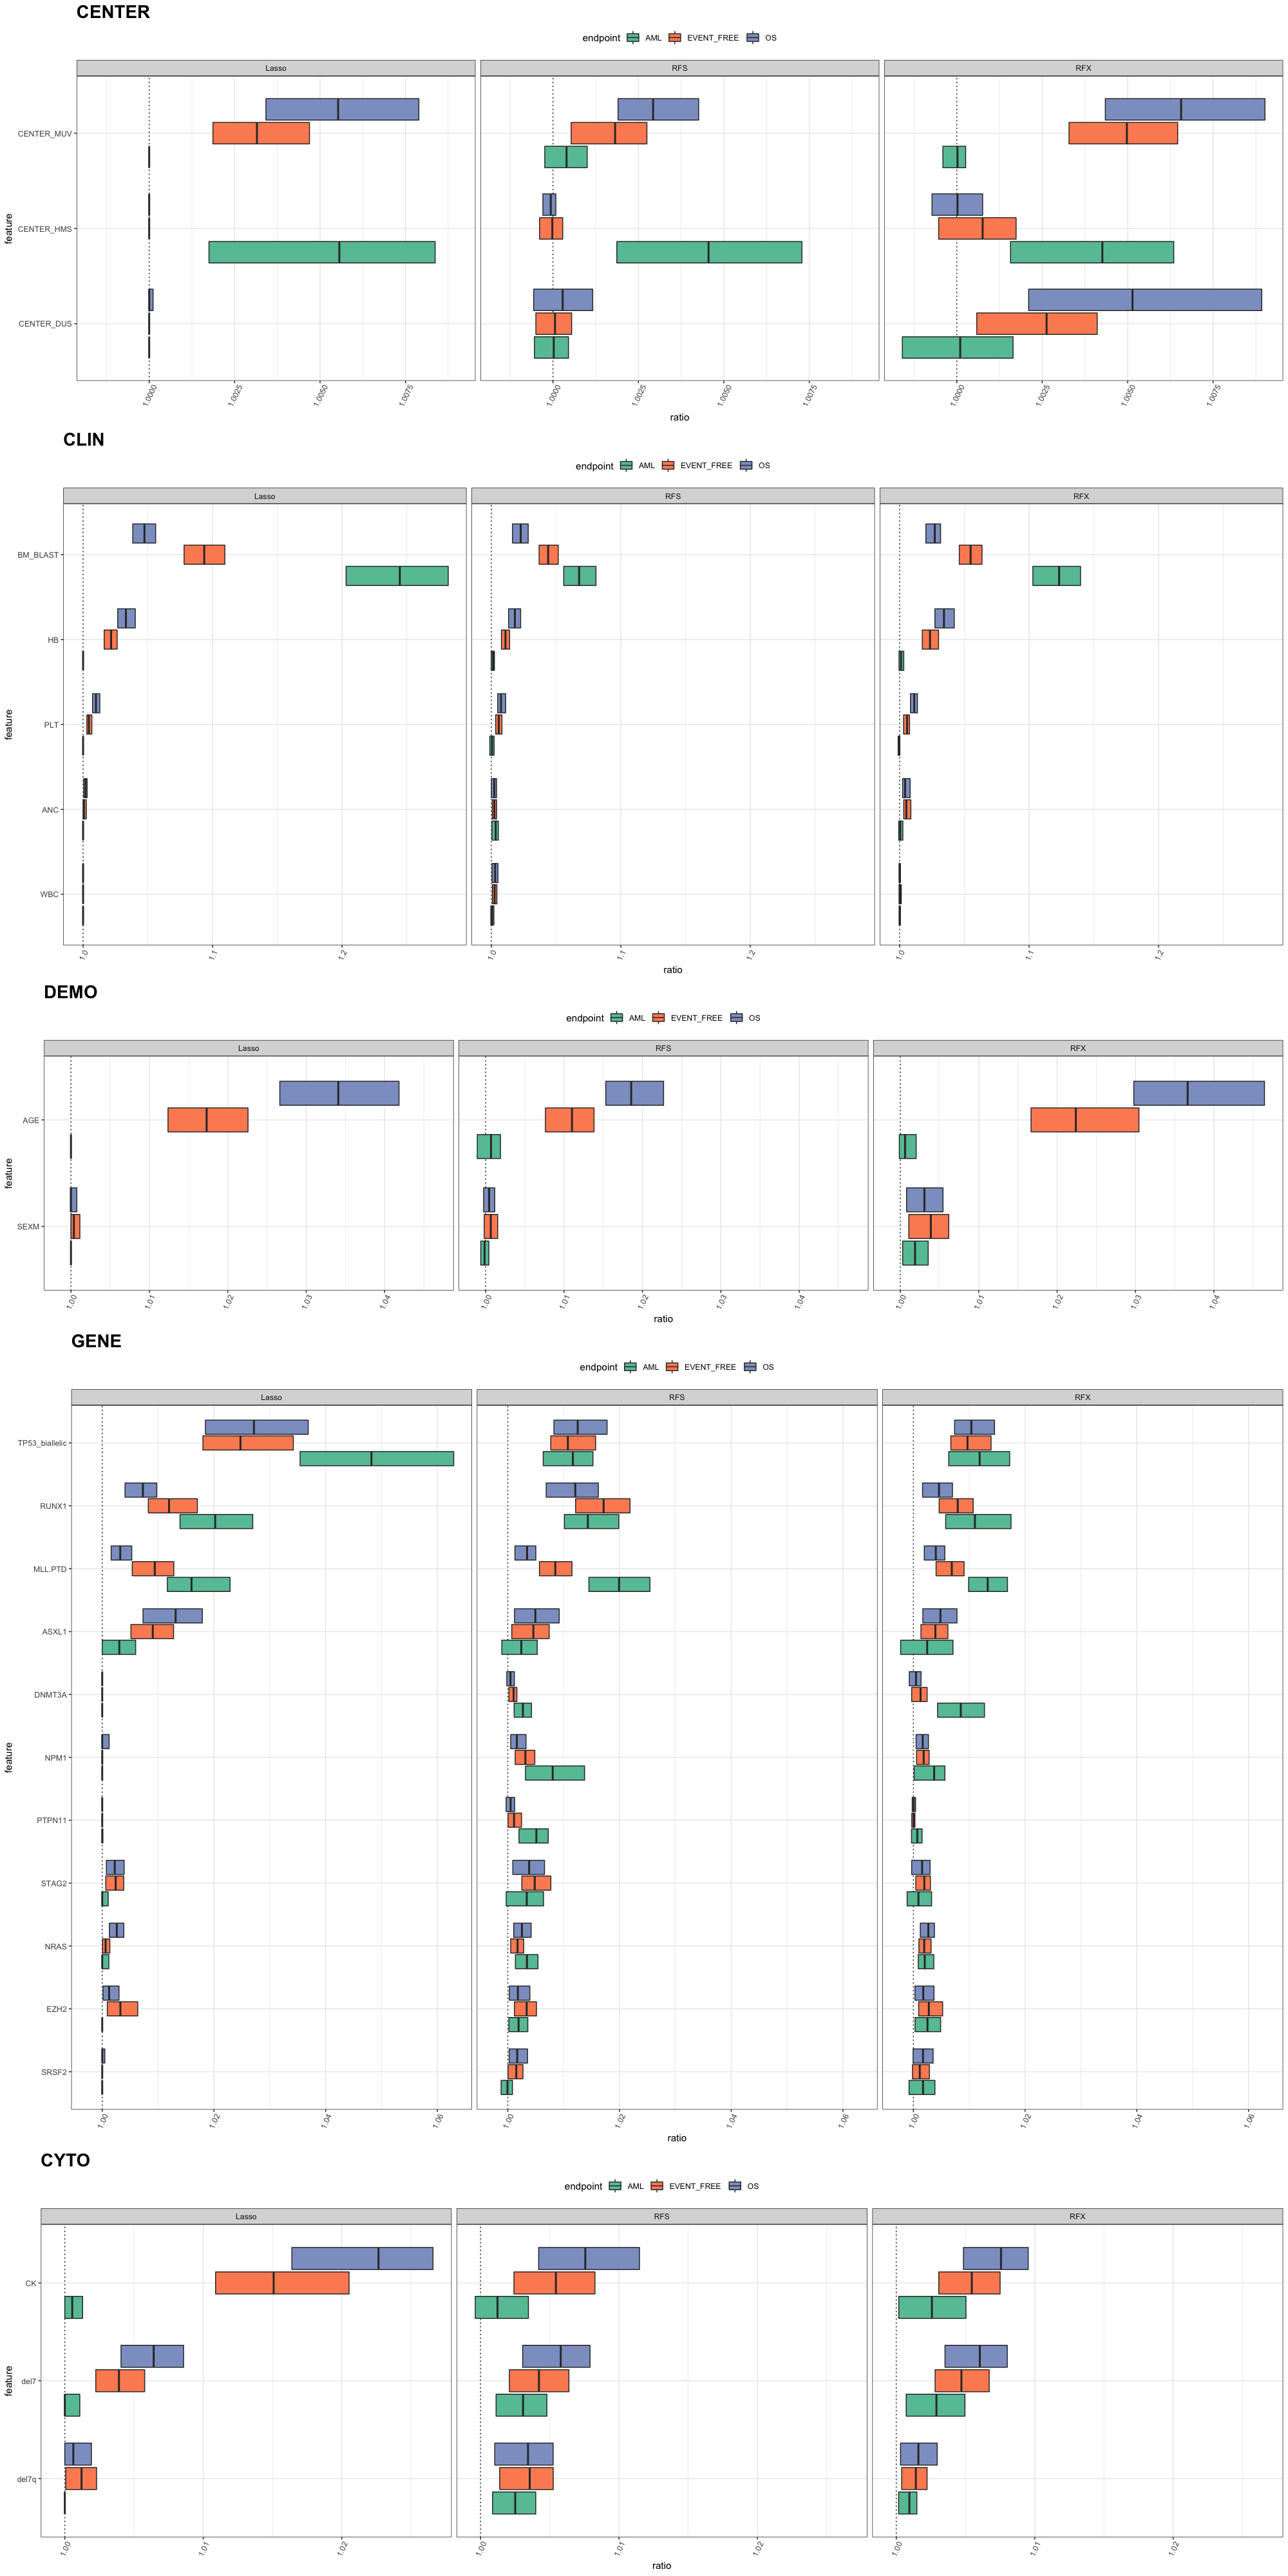

In [200]:
set_notebook_plot_size(20,40)
caterogies_boxplot(sig_features)


Very few features are selected using the significance, we could use other ways to find which feature to use for prediction:
- select the top features according to their median
- select the features that have a `median - standard deviation` above 1
- select the features that have a 1st quantile above 1

A pre-study is performed here to see which features are in each group and how many features are selected.


In [14]:
# sort features accordiang to their median
feature_median_max <- get_max_median(CLIN_DEMO_CYTO_GENE)

In [15]:
feature_median_max<-feature_median_max[order(feature_median_max$max_median,decreasing = T),]
cbind(feature_median_max[1:24,],unique(sig_features$feature))

,feature,max_median,unique(sig_features$feature)
27,BM_BLAST,1.244657,CENTER_DUS
148,TP53_biallelic,1.048198,CENTER_HMS
29,AGE,1.036649,CENTER_MUV
24,HB,1.034269,HB
272,CK,1.022659,PLT
119,RUNX1,1.020225,ANC
92,MLL.PTD,1.019920,BM_BLAST
34,ASXL1,1.013144,WBC
25,PLT,1.011302,AGE
59,DNMT3A,1.008484,SEXM


Let's see the difference between the top 24 features and the significant features:

In [261]:
as.character(feature_median_max[1:24,]$feature[!feature_median_max[1:24,]$feature%in%unique(sig_features$feature)])
as.character(unique(sig_features$feature)[!unique(sig_features$feature)%in%feature_median_max[1:24,]$feature])

[1] "U2AF1"    "WT1"      "IDH2_140" "SF3B1"

[1] "WBC"   "EZH2"  "NRAS"  "SRSF2"

In [16]:
# get standard deviation of ratio for one feature and for one couple (algo, endpoint)
get_sd<-function(data,feature,algo,endpoint){
    tmp <- data[data$feature==feature & data$algo==algo & data$endpoint==endpoint,]
    return(sd(tmp$ratio))
}
######

# get max (median-sd) ratio for all features and all couples in a given dataset
get_max_median_sd<-function(data){
    couples <- expand.grid(unique(data$algo),unique(data$endpoint))

    feature_median_sd_max <- data.frame(feature=unique(data$feature))

    feature_median_sd_max$max_median_sd <- sapply(feature_median_sd_max$feature, function(x){
        med<-apply(couples,1,function(y){return(get_summary(data,x,y[1],y[2])[3])})
        sd<-apply(couples,1,function(y){return(get_sd(data,x,y[1],y[2]))})
        return(max(med-sd))})
    
    return(feature_median_sd_max)
    
}

In [208]:
# features with median - sd >1
feature_median_sd_max <- get_max_median_sd(CLIN_DEMO_CYTO_GENE)

In [210]:
feature_median_sd_max[feature_median_sd_max$max_median_sd>1,]
nrow(feature_median_sd_max[feature_median_sd_max$max_median_sd>1,])

,feature,max_median_sd
3,CENTER_DUS,1.000615
7,CENTER_GESMD,1.000133
9,CENTER_HMS,1.001207
14,CENTER_MUV,1.003270
15,CENTER_PV,1.000624
24,HB,1.022980
25,PLT,1.006737
26,ANC,1.000083
27,BM_BLAST,1.190935
29,AGE,1.023461


[1] 26

Let's see the difference with the significant features:

In [262]:
as.character(feature_median_sd_max[feature_median_sd_max$max_median_sd>1,]$feature[!feature_median_sd_max[feature_median_sd_max$max_median_sd>1,]$feature%in%unique(sig_features$feature)])
as.character(unique(sig_features$feature)[!unique(sig_features$feature)%in%feature_median_sd_max[feature_median_sd_max$max_median_sd>1,]$feature])


[1] "CENTER_GESMD" "CENTER_PV"    "SF3B1"        "WT1"          "plus11"

[1] "WBC"   "SEXM"  "SRSF2"

If we extend the number of selected features with taking the top 60 according to their median, we get:

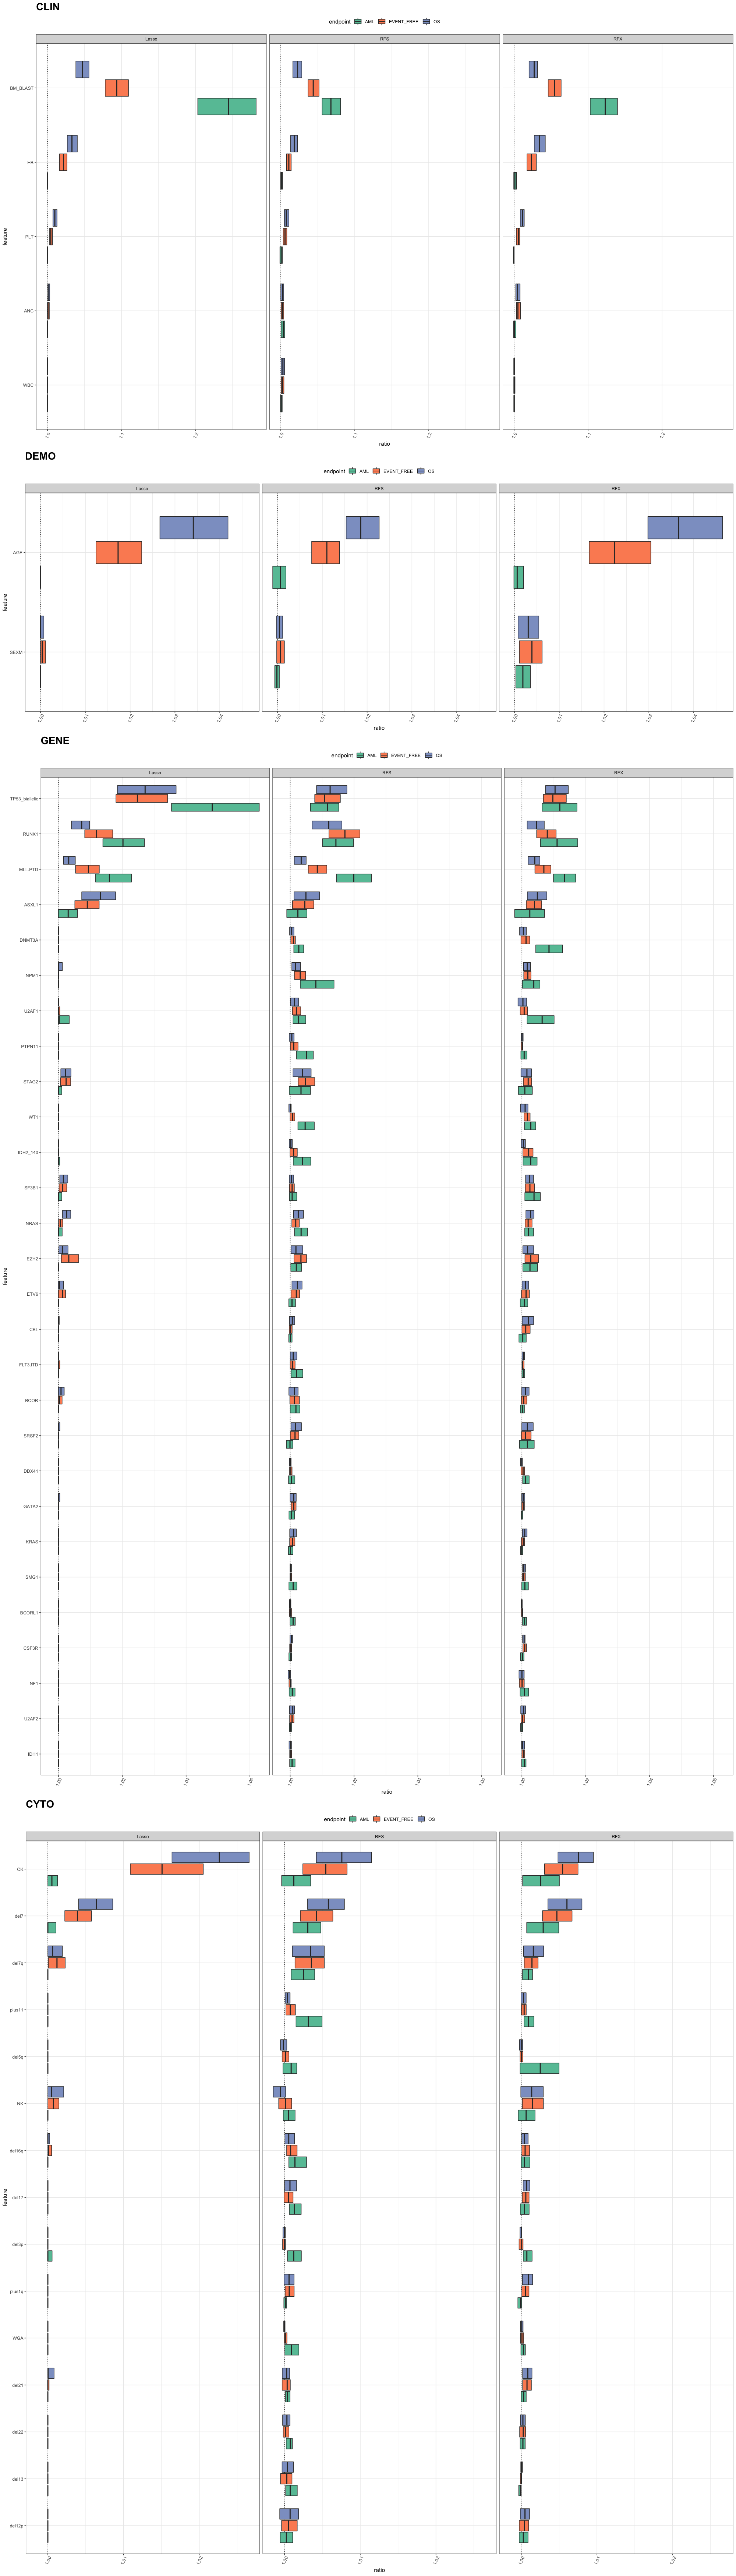

In [212]:
set_notebook_plot_size(20,70)
caterogies_boxplot(CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$feature%in%feature_median_max[1:60,'feature'],],center=F)

The features displayed here could have an impact on prognosis considering their ratio range for different endpoints.

We can also look at the features with a 1st quantile above 1:

In [17]:
get_max_1stq<-function(data){
    couples <- expand.grid(unique(data$algo),unique(data$endpoint))

    feature_max_1stq <- data.frame(feature=unique(data$feature))

    feature_max_1stq$max_1stq <- sapply(feature_max_1stq$feature, function(x){
        q1<-apply(couples,1,function(y){return(get_summary(data,x,y[1],y[2])[2])})
        return(max(q1))})
    
    return(feature_max_1stq)
    
}

In [218]:
feature_max_1stq <- get_max_1stq(CLIN_DEMO_CYTO_GENE)

In [248]:
nrow(feature_max_1stq[feature_max_1stq$max_1stq>1,])
head(feature_max_1stq[feature_max_1stq$max_1stq>1,])

[1] 60

,feature,max_1stq
3,CENTER_DUS,1.002104
6,CENTER_FUCE,1.000042
7,CENTER_GESMD,1.000956
8,CENTER_HIAE,1.000264
9,CENTER_HMS,1.001868
14,CENTER_MUV,1.004347


Sixty features are selected with this method, let's compare them to the top 60 according to their median:

In [263]:
as.character(feature_median_max[1:60,]$feature[!feature_median_max[1:60,]$feature%in%feature_max_1stq[feature_max_1stq$max_1stq>1,]$feature])
as.character(feature_max_1stq[feature_max_1stq$max_1stq>1,]$feature[!feature_max_1stq[feature_max_1stq$max_1stq>1,]$feature%in%feature_median_max[1:60,]$feature])

[1] "del5q"       "CENTER_RMCN" "CENTER_KI"   "CENTER_CGM"  "NF1"        
[6] "U2AF2"       "del12p"      "IDH1"

[1] "ATRX"   "NFE2"   "PHIP"   "PPM1D"  "PTPRF"  "YLPM1"  "plus1p" "del15"

### Prognosis for those models

We will compare in this section the impact of changing the models for prognosis for 3 endpoints. The models considered here are:
- significant features
- features with median - sd > 1
- features with 1st quantile > 1
- features with 1st quantile > 1 + del5q 
- top 40 features
- top 50 features
- top 60 features
- top 70 features
- features with median > 1
- all features from CLIN DEMO CYTO GENE model

We use all centers for all models to prevent from adding a bias. We perform ten 5-fold CV with random effects and we display the results here:

#### OS

In [318]:
sig_feat <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_sig_feat.tsv',sep='\t')
med_sd_feat <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_med_sd_feat.tsv',sep='\t')
q1_feat <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_q1_feat.tsv',sep='\t')
q1_del5q_feat <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_q1_del5q_feat.tsv',sep='\t')
feat_imp40 <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp40.tsv',sep='\t')
feat_imp50 <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp50.tsv',sep='\t')
feat_imp60 <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp60.tsv',sep='\t')
feat_imp70 <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp70.tsv',sep='\t')
median_feat <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_median_feat.tsv',sep='\t')
full <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_full.tsv',sep='\t')

models <- rbind(feat_imp40,
                feat_imp50,
                feat_imp60,
                feat_imp70,
                sig_feat,
                med_sd_feat,
                q1_feat,
                q1_del5q_feat,
                median_feat,
                full)
models$model<-factor(models$model,levels=c('sig_feat',
                'med_sd_feat',
                'q1_feat',
                'q1_del5q_feat',
                'feat_imp40',
                'feat_imp50',
                'feat_imp60',
                'feat_imp70',
                'median_feat',
                'full'))


In [319]:
set_notebook_plot_size(15,10)

medians <- data.frame(models=levels(models$model))
medians$med <- signif(sapply(levels(models$model),function(x){return(median(models$RFX[models$model==as.character(x)]))}),5)

comparisons<-list(c(3,4),c(3,7),c(7,8))

g1<-ggplot(models,aes(x=model,y=RFX)) +
    geom_boxplot(aes(fill = model), notch=T,outlier.shape = NA)+
    scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd'))+
    geom_hline(yintercept = median(models$RFX), linetype = 2)+
    geom_text(aes(models, med+0.002, label=med,fill=NULL),data=medians )+
    theme(legend.position="none",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) +
    stat_compare_means(paired = T, comparisons = comparisons)+
    ggtitle('OS Concordance index using random effects')+
    scale_x_discrete(labels=c('significant',
                             'median - sd > 1',
                             '1st quantile > 1',
                             '1st quantile > 1 + del5q',
                             'top 40',
                             'top 50',
                             'top 60',
                             'top 70',
                             'median > 1',
                             'full'))





#### AML transformation

In [320]:
sig_feat_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_sig_feat_AML.tsv',sep='\t')
med_sd_feat_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_med_sd_feat_AML.tsv',sep='\t')
q1_feat_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_q1_feat_AML.tsv',sep='\t')
q1_del5q_feat_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_q1_del5q_feat_AML.tsv',sep='\t')
feat_imp40_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp40_AML.tsv',sep='\t')
feat_imp50_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp50_AML.tsv',sep='\t')
feat_imp60_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp60_AML.tsv',sep='\t')
feat_imp70_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp70_AML.tsv',sep='\t')
median_feat_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_median_feat_AML.tsv',sep='\t')
full_AML <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_full_AML.tsv',sep='\t')

models_AML <- rbind(feat_imp40_AML,
                feat_imp50_AML,
                feat_imp60_AML,
                feat_imp70_AML,
                sig_feat_AML,
                med_sd_feat_AML,
                q1_feat_AML,
                q1_del5q_feat_AML,
                median_feat_AML,
                full_AML)
models_AML$model<-factor(models_AML$model,levels=c('sig_feat',
                'med_sd_feat',
                'q1_feat',
                'q1_del5q_feat',
                'feat_imp40',
                'feat_imp50',
                'feat_imp60',
                'feat_imp70',
                'median_feat',
                'full'))


In [321]:
set_notebook_plot_size(15,10)

medians <- data.frame(models=levels(models_AML$model))
medians$med <- signif(sapply(levels(models_AML$model),function(x){return(median(models_AML$RFX[models_AML$model==as.character(x)]))}),5)

comparisons<-list(c(3,4),c(3,7),c(7,8))

g2<-ggplot(models_AML,aes(x=model,y=RFX)) +
    geom_boxplot(aes(fill = model), notch=T,outlier.shape = NA)+
    scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd'))+
    geom_hline(yintercept = median(models_AML$RFX), linetype = 2)+
    geom_text(aes(models, med+0.002, label=med,fill=NULL),data=medians )+
    theme(legend.position="none",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) +
    stat_compare_means(paired = T, comparisons = comparisons)+
    ggtitle('AML transformation Concordance index using random effects')+
    scale_x_discrete(labels=c('significant',
                             'median - sd > 1',
                             '1st quantile > 1',
                             '1st quantile > 1 + del5q',
                             'top 40',
                             'top 50',
                             'top 60',
                             'top 70',
                             'median > 1',
                             'full'))





#### Event free survival

In [322]:
sig_feat_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_sig_feat_EVENT.tsv',sep='\t')
med_sd_feat_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_med_sd_feat_EVENT.tsv',sep='\t')
q1_feat_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_q1_feat_EVENT.tsv',sep='\t')
q1_del5q_feat_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_q1_del5q_feat_EVENT.tsv',sep='\t')
feat_imp40_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp40_EVENT.tsv',sep='\t')
feat_imp50_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp50_EVENT.tsv',sep='\t')
feat_imp60_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp60_EVENT.tsv',sep='\t')
feat_imp70_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_feat_imp70_EVENT.tsv',sep='\t')
median_feat_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_median_feat_EVENT.tsv',sep='\t')
full_EVENT <- read.table('../../data/updated_dataset//prediction/prognosis_featImp_full_EVENT.tsv',sep='\t')

models_EVENT <- rbind(feat_imp40_EVENT,
                feat_imp50_EVENT,
                feat_imp60_EVENT,
                feat_imp70_EVENT,
                sig_feat_EVENT,
                med_sd_feat_EVENT,
                q1_feat_EVENT,
                q1_del5q_feat_EVENT,
                median_feat_EVENT,
                full_EVENT)
models_EVENT$model<-factor(models_EVENT$model,levels=c('sig_feat',
                'med_sd_feat',
                'q1_feat',
                'q1_del5q_feat',
                'feat_imp40',
                'feat_imp50',
                'feat_imp60',
                'feat_imp70',
                'median_feat',
                'full'))


In [323]:
set_notebook_plot_size(15,10)

medians <- data.frame(models=levels(models_EVENT$model))
medians$med <- signif(sapply(levels(models_EVENT$model),function(x){return(median(models_EVENT$RFX[models_EVENT$model==as.character(x)]))}),5)

comparisons<-list(c(3,4),c(3,7),c(7,8))

g3<-ggplot(models_EVENT,aes(x=model,y=RFX)) +
    geom_boxplot(aes(fill = model), notch=T,outlier.shape = NA)+
    scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd'))+
    geom_hline(yintercept = median(models_EVENT$RFX), linetype = 2)+
    geom_text(aes(models, med+0.002, label=med,fill=NULL),data=medians )+
    theme(legend.position="none",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) +
    stat_compare_means(paired = T, comparisons = comparisons)+
    ggtitle('Event free survival Concordance index using random effects')+
    scale_x_discrete(labels=c('significant',
                             'median - sd > 1',
                             '1st quantile > 1',
                             '1st quantile > 1 + del5q',
                             'top 40',
                             'top 50',
                             'top 60',
                             'top 70',
                             'median > 1',
                             'full'))






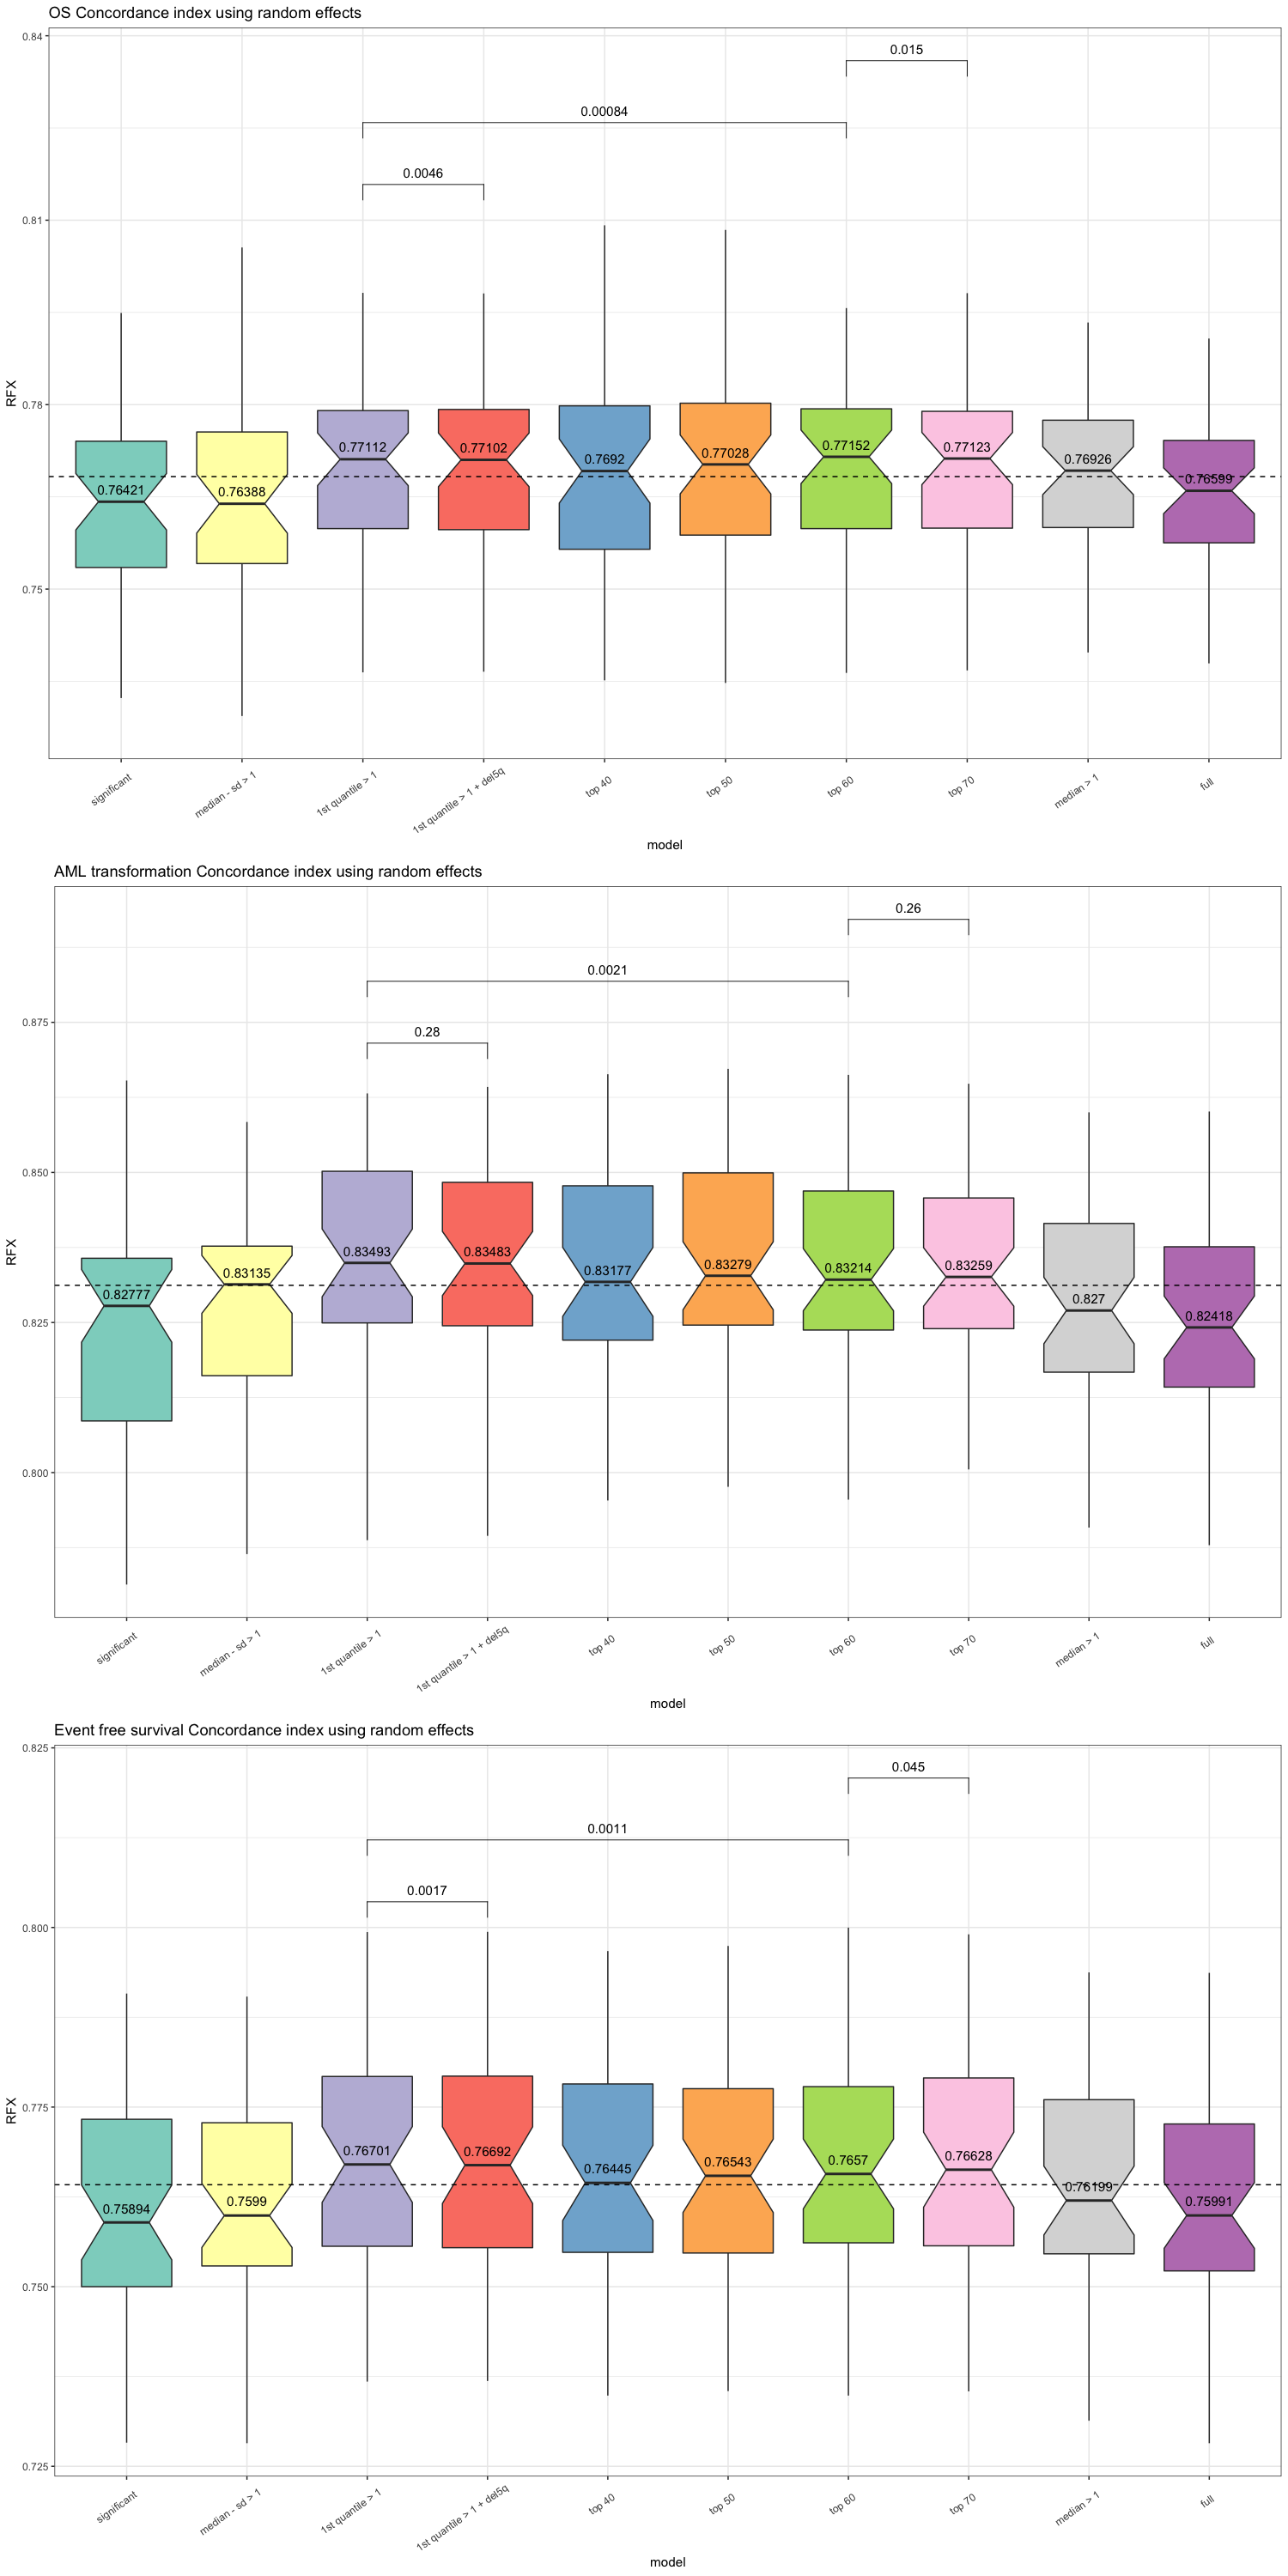

In [324]:
set_notebook_plot_size(15,30)
grid.arrange(g1,g2,g3,ncol=1)

`del5q` seems to reduce the concordance index, but it may be because it is very correlated to both cases that are CK | TP53-biallelic and poor prognosis  while cases that are isolated del5q have good prognosis.

Let's look at the feature importance for the model keeping the features having a 1st quantile above 1 for at least one endpoint in one algorithm:

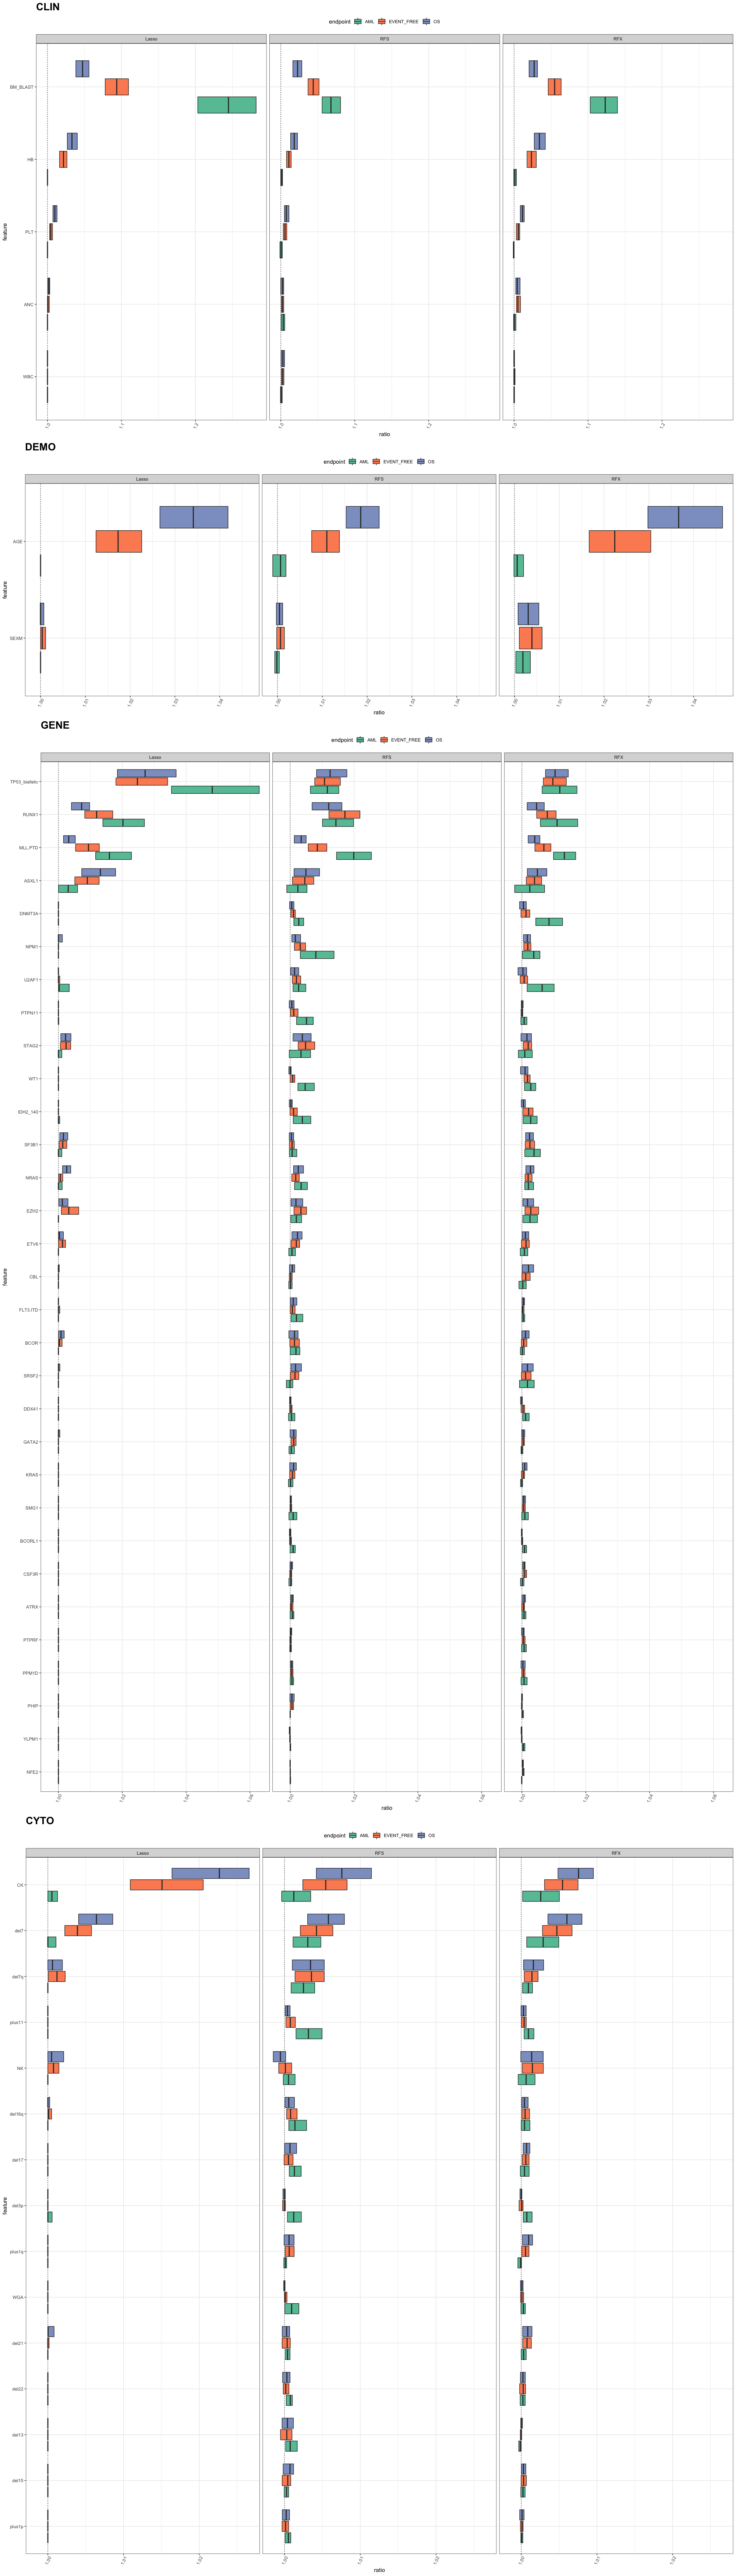

In [289]:
set_notebook_plot_size(20,70)
caterogies_boxplot(CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$feature%in%feature_max_1stq[feature_max_1stq$max_1stq>1,'feature'],],center=F)

### CLIN DEMO CYTO GENE NMUT
Let's add the number of mutations to the features to see if it is an important one:


In [18]:
CLIN_DEMO_CYTO_GENE_NMUT_AML <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_NMUT_AML.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_NMUT_AML$endpoint<-'AML'
CLIN_DEMO_CYTO_GENE_NMUT_EVENT <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_NMUT_EVENT_FREE.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_NMUT_EVENT$endpoint<-'EVENT_FREE'
CLIN_DEMO_CYTO_GENE_NMUT_OS <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_NMUT_OS.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_NMUT_OS$endpoint<-'OS'    

CLIN_DEMO_CYTO_GENE_NMUT<-rbind(CLIN_DEMO_CYTO_GENE_NMUT_OS,
                           CLIN_DEMO_CYTO_GENE_NMUT_AML,
                           CLIN_DEMO_CYTO_GENE_NMUT_EVENT)



In [19]:
nmut <- CLIN_DEMO_CYTO_GENE_NMUT[CLIN_DEMO_CYTO_GENE_NMUT$feature=='num_mutations',]
nmut$ratio <- nmut$ref_CI/nmut$permuted_CI
nmut$category<-"NMUT"

nmut_pval_OS<-data.frame(feature='num_mutations')
nmut_pval_OS$Lasso<-get_pval(nmut,'num_mutations','Lasso','OS')$p.value
nmut_pval_OS$RFS<-get_pval(nmut,'num_mutations','RFS','OS')$p.value
nmut_pval_OS$RFX<-get_pval(nmut,'num_mutations','RFX','OS')$p.value
nmut_pval_OS$endpoint<-'OS'

nmut_pval_EVENT<-data.frame(feature='num_mutations')
nmut_pval_EVENT$Lasso<-get_pval(nmut,'num_mutations','Lasso','EVENT_FREE')$p.value
nmut_pval_EVENT$RFS<-get_pval(nmut,'num_mutations','RFS','EVENT_FREE')$p.value
nmut_pval_EVENT$RFX<-get_pval(nmut,'num_mutations','RFX','EVENT_FREE')$p.value
nmut_pval_EVENT$endpoint<-'EVENT_FREE'

nmut_pval_AML<-data.frame(feature='num_mutations')
nmut_pval_AML$Lasso<-get_pval(nmut,'num_mutations','Lasso','AML')$p.value
nmut_pval_AML$RFS<-get_pval(nmut,'num_mutations','RFS','AML')$p.value
nmut_pval_AML$RFX<-get_pval(nmut,'num_mutations','RFX','AML')$p.value
nmut_pval_AML$endpoint<-'AML'

nmut_pval<-rbind(nmut_pval_OS,
                nmut_pval_AML,
                nmut_pval_EVENT)
nmut_pval

feature,Lasso,RFS,RFX,endpoint
num_mutations,3.743918e-21,0.06924473,0.5584220,OS
num_mutations,6.985005e-09,0.96336091,0.2014052,AML
num_mutations,3.113822e-18,0.69005590,0.6900522,EVENT_FREE


Lasso selects very few features in fact, so having the number of mutations is important in this setting. But RFX and RFS are giving importance to much more parameters, so adding the number of mutations can either be seen as redundant or overfitting.

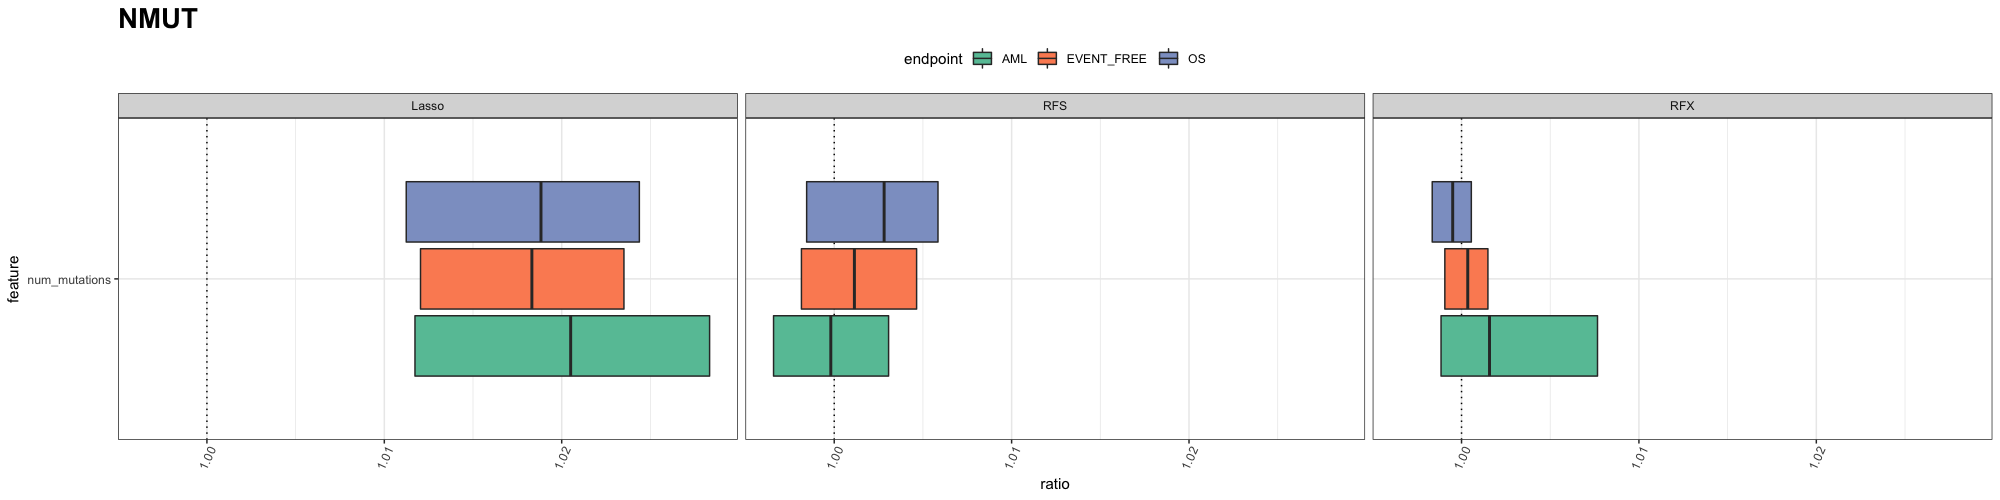

In [36]:
set_notebook_plot_size(20,5)
caterogies_boxplot(nmut)

# Long version
We use in this section the same algorithm but with 5 5-fold CV and 20 permutations for each feature in each CV, for a total of 500 concordance index for each feature. 

For the model *CLIN_DEMO_CYTO_GENE*:


In [20]:
CLIN_DEMO_CYTO_GENE_AML_long <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_AML_long.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_AML_long$endpoint<-'AML'
CLIN_DEMO_CYTO_GENE_EVENT_long <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_EVENT_FREE_long.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_EVENT_long$endpoint<-'EVENT_FREE'
CLIN_DEMO_CYTO_GENE_OS_long <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_GENE_OS_long.tsv',sep='\t')
CLIN_DEMO_CYTO_GENE_OS_long$endpoint<-'OS'    

CLIN_DEMO_CYTO_GENE_long<-rbind(CLIN_DEMO_CYTO_GENE_OS_long,
                           CLIN_DEMO_CYTO_GENE_AML_long,
                           CLIN_DEMO_CYTO_GENE_EVENT_long)



In [21]:
CLIN_DEMO_CYTO_GENE_long$ratio <- CLIN_DEMO_CYTO_GENE_long$ref_CI/CLIN_DEMO_CYTO_GENE_long$permuted_CI
CLIN_DEMO_CYTO_GENE_long$feature<-factor(CLIN_DEMO_CYTO_GENE_long$feature,levels=colnames(prep.CLIN_DEMO_CYTO_GENE$design))
CLIN_DEMO_CYTO_GENE_long$category<-as.character(sapply(CLIN_DEMO_CYTO_GENE_long$feature,get_category))
features_pval_OS_long <- data.frame(feature=unique(CLIN_DEMO_CYTO_GENE_long$feature))

features_pval_OS_long$Lasso <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'Lasso','OS')$p.value)})
features_pval_OS_long$RFX <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'RFX','OS')$p.value)})
features_pval_OS_long$RFS <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'RFS','OS')$p.value)})
features_pval_OS_long$endpoint <- 'OS'

features_pval_AML_long <- data.frame(feature=unique(CLIN_DEMO_CYTO_GENE_long$feature))

features_pval_AML_long$Lasso <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'Lasso','AML')$p.value)})
features_pval_AML_long$RFX <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'RFX','AML')$p.value)})
features_pval_AML_long$RFS <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'RFS','AML')$p.value)})
features_pval_AML_long$endpoint <- 'AML'

features_pval_EVENT_long <- data.frame(feature=unique(CLIN_DEMO_CYTO_GENE_long$feature))

features_pval_EVENT_long$Lasso <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'Lasso','EVENT_FREE')$p.value)})
features_pval_EVENT_long$RFX <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'RFX','EVENT_FREE')$p.value)})
features_pval_EVENT_long$RFS <- sapply(features_pval_OS_long$feature, function(x){return(get_pval(CLIN_DEMO_CYTO_GENE_long,as.character(x),'RFS','EVENT_FREE')$p.value)})
features_pval_EVENT_long$endpoint <- 'EVENT_FREE'


features_pval_long<- rbind(features_pval_OS_long,
                      features_pval_AML_long,
                      features_pval_EVENT_long)

head(features_pval_long)


feature,Lasso,RFX,RFS,endpoint
CENTER_CCH,0.9389545,6.145460e-01,0.9686425,OS
CENTER_CGM,1.0000000,3.116919e-01,0.7709261,OS
CENTER_DUS,0.6676683,6.979218e-08,0.4972667,OS
CENTER_DUTH,1.0000000,8.352715e-01,0.6886676,OS
CENTER_FLO,1.0000000,8.351921e-01,0.9861002,OS
CENTER_FUCE,1.0000000,3.463992e-01,0.7162794,OS


In [22]:
sig_features_long <- CLIN_DEMO_CYTO_GENE_long[CLIN_DEMO_CYTO_GENE_long$feature %in% unique(features_pval_long$feature[features_pval_long$Lasso < 0.05 | 
                                                                                                  features_pval_long$RFX < 0.05  | 
                                                                                                  features_pval_long$RFS < 0.05]),]


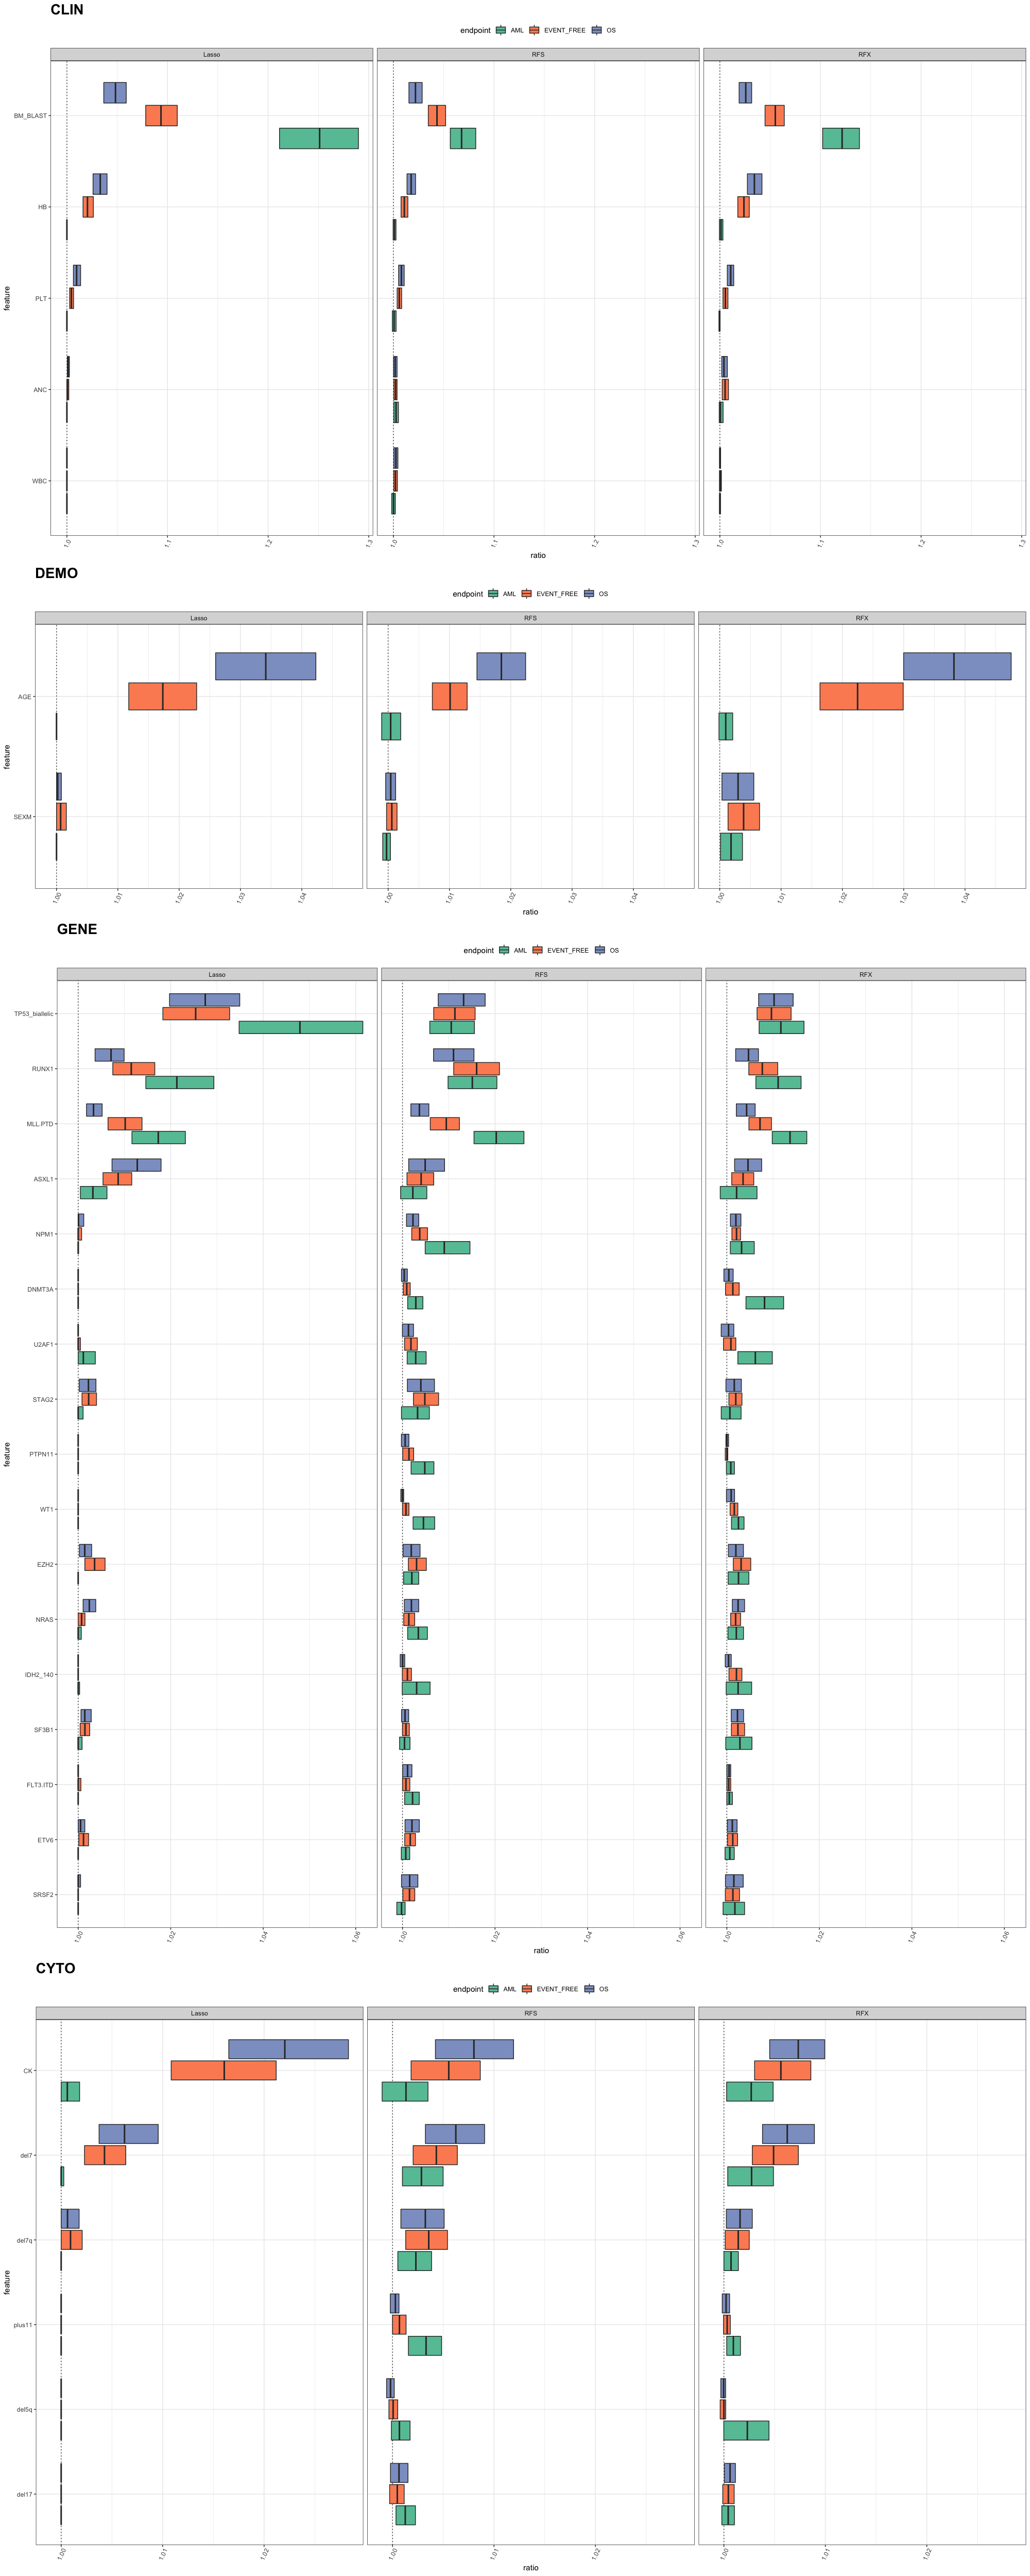

In [352]:
set_notebook_plot_size(20,50)
caterogies_boxplot(sig_features_long,center = FALSE)


In [354]:
features_pval_long[features_pval_long$feature%in%c('RUNX1', 'IDH1', 'IDH2_140','IDH2_172', 'ASXL1', 'MLL.PTD')&features_pval_long$endpoint=='AML',]


,feature,Lasso,RFX,RFS,endpoint
306,ASXL1,1.052624e-02,7.866706e-02,1.277642e-02,AML
348,IDH1,1.000000e+00,9.424736e-01,4.958801e-01,AML
349,IDH2_140,9.511748e-01,2.593798e-02,4.354186e-03,AML
350,IDH2_172,1.000000e+00,9.459488e-01,7.211392e-01,AML
364,MLL.PTD,9.833313e-24,2.040983e-23,6.129859e-47,AML
391,RUNX1,4.382723e-34,6.484048e-15,9.684520e-30,AML


In [362]:
features_pval_long[features_pval_long$endpoint=='AML' & (features_pval_long$Lasso<0.05 |
                                                        features_pval_long$RFS<0.05 |
                                                        features_pval_long$RFX<0.05),][4:18,]


,feature,Lasso,RFX,RFS,endpoint
306,ASXL1,1.052624e-02,7.866706e-02,1.277642e-02,AML
331,DNMT3A,1.000000e+00,6.935392e-09,2.510192e-03,AML
338,EZH2,9.703688e-01,1.878450e-02,2.148175e-02,AML
341,FLT3.ITD,7.292901e-01,3.882275e-01,5.634938e-03,AML
349,IDH2_140,9.511748e-01,2.593798e-02,4.354186e-03,AML
364,MLL.PTD,9.833313e-24,2.040983e-23,6.129859e-47,AML
372,NPM1,7.227149e-01,1.392139e-02,4.116040e-17,AML
373,NRAS,7.557982e-01,8.802394e-02,2.615810e-04,AML
381,PTPN11,9.476756e-01,3.044148e-01,4.634826e-05,AML
391,RUNX1,4.382723e-34,6.484048e-15,9.684520e-30,AML


In [370]:
features_pval_long[features_pval_long$feature%in%c('BM_BLAST','ANC','PLT','HB','WBC','AGE'),]


,feature,Lasso,RFX,RFS,endpoint
24,HB,8.559497e-93,6.128743e-105,4.509612e-57,OS
25,PLT,4.603577e-17,8.849192e-23,8.270838e-19,OS
26,ANC,4.748902e-02,7.789505e-07,9.043886e-03,OS
27,BM_BLAST,1.746168e-148,3.031186e-89,4.713907e-78,OS
28,WBC,1.000000e+00,6.253615e-01,3.584227e-03,OS
29,AGE,2.073250e-108,1.363780e-128,6.064147e-66,OS
296,HB,1.000000e+00,1.859468e-01,1.435161e-01,AML
297,PLT,1.000000e+00,4.279608e-01,4.028860e-01,AML
298,ANC,1.000000e+00,6.681172e-02,6.661277e-03,AML
299,BM_BLAST,5.433897e-165,8.782434e-165,2.126772e-147,AML


### CYTO GENE

In [23]:
# CYTO_GENE
prep.CYTO_GENE = PrepareDesignMatrix(data=ddgo,
                                 use.nuisance=TRUE,
                                 response.name=c("time","status"),
                                 feature.category.name = c("cytoaberrations","mutations"),
                                 list.features=list.features)


In [24]:
CYTO_GENE_AML_long <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CYTO_GENE_AML_long.tsv',sep='\t')
CYTO_GENE_AML_long$endpoint<-'AML'
CYTO_GENE_EVENT_long <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CYTO_GENE_EVENT_FREE_long.tsv',sep='\t')
CYTO_GENE_EVENT_long$endpoint<-'EVENT_FREE'
CYTO_GENE_OS_long <- read.table('../../data/updated_dataset/feature_importance/feature_importance_CYTO_GENE_OS_long.tsv',sep='\t')
CYTO_GENE_OS_long$endpoint<-'OS'    

CYTO_GENE_long<-rbind(CYTO_GENE_OS_long,
                           CYTO_GENE_AML_long,
                           CYTO_GENE_EVENT_long)



In [25]:
CYTO_GENE_long$ratio <- CYTO_GENE_long$ref_CI/CYTO_GENE_long$permuted_CI
CYTO_GENE_long$feature<-factor(CYTO_GENE_long$feature,levels=colnames(prep.CYTO_GENE$design))
CYTO_GENE_long$category<-as.character(sapply(CYTO_GENE_long$feature,get_category))
features_pval_CYTO_GENE_OS_long <- data.frame(feature=unique(CYTO_GENE_long$feature))

features_pval_CYTO_GENE_OS_long$Lasso <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'Lasso','OS')$p.value)})
features_pval_CYTO_GENE_OS_long$RFX <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'RFX','OS')$p.value)})
features_pval_CYTO_GENE_OS_long$RFS <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'RFS','OS')$p.value)})
features_pval_CYTO_GENE_OS_long$endpoint <- 'OS'

features_pval_CYTO_GENE_AML_long <- data.frame(feature=unique(CYTO_GENE_long$feature))

features_pval_CYTO_GENE_AML_long$Lasso <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'Lasso','AML')$p.value)})
features_pval_CYTO_GENE_AML_long$RFX <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'RFX','AML')$p.value)})
features_pval_CYTO_GENE_AML_long$RFS <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'RFS','AML')$p.value)})
features_pval_CYTO_GENE_AML_long$endpoint <- 'AML'

features_pval_CYTO_GENE_EVENT_long <- data.frame(feature=unique(CYTO_GENE_long$feature))

features_pval_CYTO_GENE_EVENT_long$Lasso <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'Lasso','EVENT_FREE')$p.value)})
features_pval_CYTO_GENE_EVENT_long$RFX <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'RFX','EVENT_FREE')$p.value)})
features_pval_CYTO_GENE_EVENT_long$RFS <- sapply(features_pval_CYTO_GENE_OS_long$feature, function(x){return(get_pval(CYTO_GENE_long,as.character(x),'RFS','EVENT_FREE')$p.value)})
features_pval_CYTO_GENE_EVENT_long$endpoint <- 'EVENT_FREE'


features_pval_CYTO_GENE_long<- rbind(features_pval_CYTO_GENE_OS_long,
                      features_pval_CYTO_GENE_AML_long,
                      features_pval_CYTO_GENE_EVENT_long)

head(features_pval_CYTO_GENE_long)


feature,Lasso,RFX,RFS,endpoint
CENTER_CCH,1.000000,0.82332253,0.9372465,OS
CENTER_CGM,1.000000,0.02982667,0.3692935,OS
CENTER_DUS,1.000000,0.02074765,0.2962412,OS
CENTER_DUTH,0.898943,0.45922946,0.7927878,OS
CENTER_FLO,1.000000,0.80962216,0.7877183,OS
CENTER_FUCE,1.000000,0.11088658,0.6822290,OS


In [30]:
features_pval_CYTO_GENE_long[features_pval_CYTO_GENE_long$feature=='DDX41',]
features_pval_long[features_pval_long$feature=='DDX41',]

,feature,Lasso,RFX,RFS,endpoint
48,DDX41,1.0000000,5.168978e-01,0.416569988,OS
313,DDX41,0.8678117,2.539057e-09,0.008372476,AML
578,DDX41,1.0000000,4.084342e-04,0.048985605,EVENT_FREE


,feature,Lasso,RFX,RFS,endpoint
55,DDX41,1,0.8644485,0.9111544,OS
327,DDX41,1,0.2659579,0.5916509,AML
599,DDX41,1,0.4672400,0.8644496,EVENT_FREE


In [384]:
features_pval_CYTO_GENE_long[features_pval_CYTO_GENE_long$feature=='WGA',]
sum(prep.CYTO_GENE$design[,'WGA'])
nrow(prep.CYTO_GENE$design)

,feature,Lasso,RFX,RFS,endpoint
188,WGA,1,0.7113709,0.85069320,OS
453,WGA,1,0.3786935,0.00853405,AML
718,WGA,1,0.4645485,0.23183645,EVENT_FREE


[1] 16

[1] 2429

Only 16 out of 2429 patients have `WGA`, which is borderline significant for random forests for AML transformation.

In [26]:
sig_features_CYTO_GENE_long <- CYTO_GENE_long[CYTO_GENE_long$feature %in% unique(features_pval_CYTO_GENE_long$feature[features_pval_CYTO_GENE_long$Lasso < 0.05 | 
                                                                                                  features_pval_CYTO_GENE_long$RFX < 0.05  | 
                                                                                                  features_pval_CYTO_GENE_long$RFS < 0.05]),]


In [380]:
unique(sig_features_CYTO_GENE_long$feature)[which(!unique(sig_features_CYTO_GENE_long$feature)%in%unique(sig_features_long$feature))]
unique(sig_features_long$feature)[which(!unique(sig_features_long$feature)%in%unique(sig_features_CYTO_GENE_long$feature))]

[1] CENTER_CGM  CENTER_HIAE CENTER_KI   CENTER_TUD  BCOR        CBL        
 [7] DDX41       GATA2       IDH1        WGA        
265 Levels: CENTER_CCH CENTER_CGM CENTER_DUS CENTER_DUTH ... U2AF1

[1] HB       PLT      ANC      BM_BLAST WBC      AGE      SEXM    
272 Levels: CENTER_CCH CENTER_CGM CENTER_DUS CENTER_DUTH ... U2AF1

This model selects BCOR, CBL, DDX41, GATA2, IDH1 and WGA on top of the features selected by the model CLIN DEMO CYTO GENE.

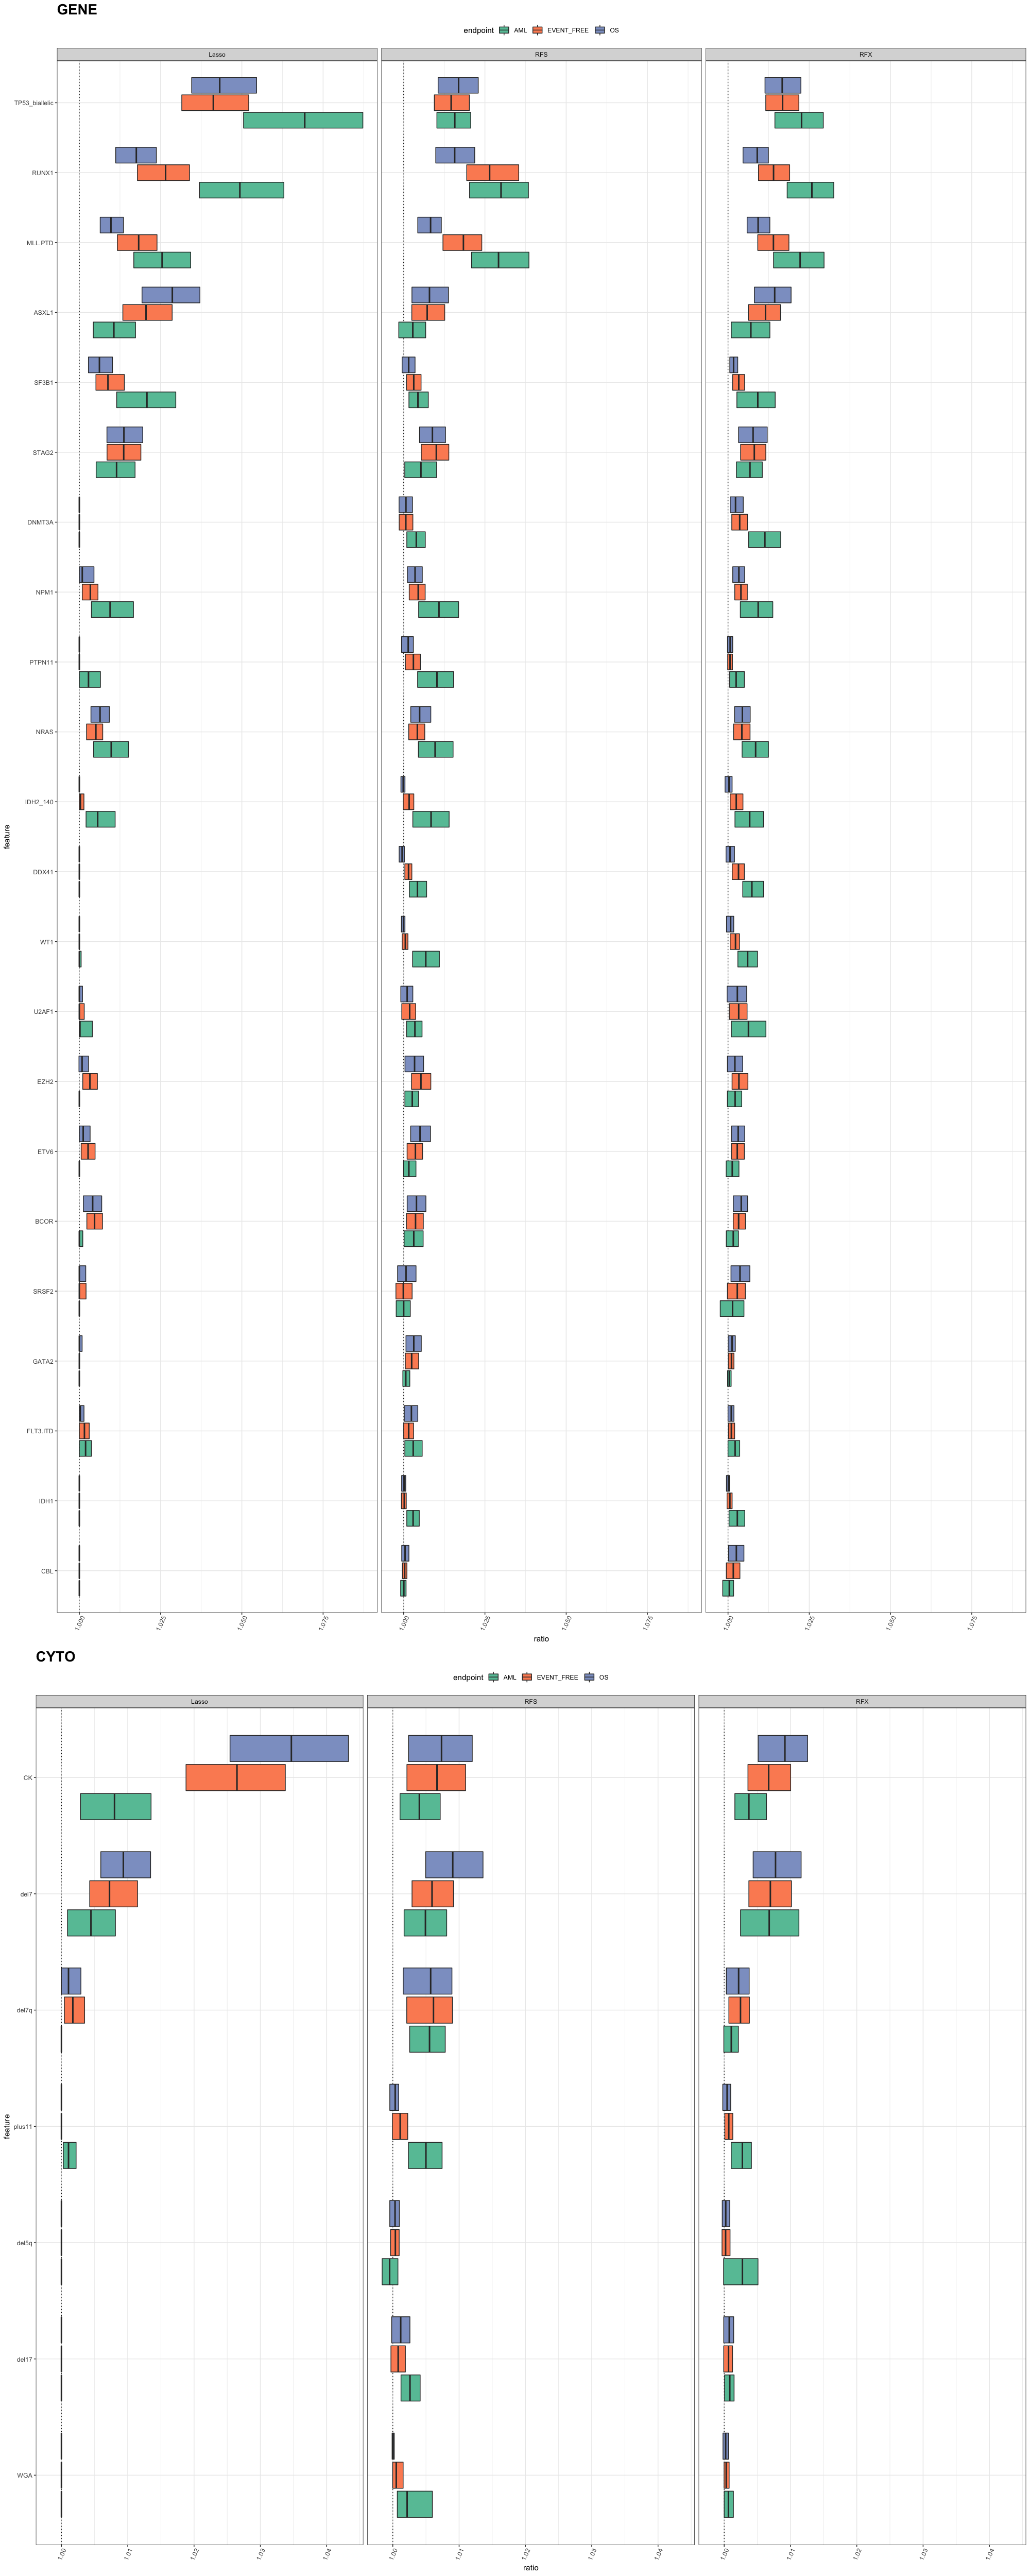

In [376]:
set_notebook_plot_size(20,50)
caterogies_boxplot(sig_features_CYTO_GENE_long,center = FALSE)